## Import Libraries and Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import gensim

from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Flatten, Dropout, Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
df = pd.read_csv('train.csv', index_col = 'id')
df.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## EDA

In [7]:
df.isna().sum()

title      558
author    1957
text        39
label        0
dtype: int64

In [8]:
df.shape

(20800, 4)

In [5]:
df.drop('author', axis = 1, inplace = True)
df.dropna(inplace = True)

In [75]:
fake = df[df['label'] == 1]
real = df[df['label'] == 0]

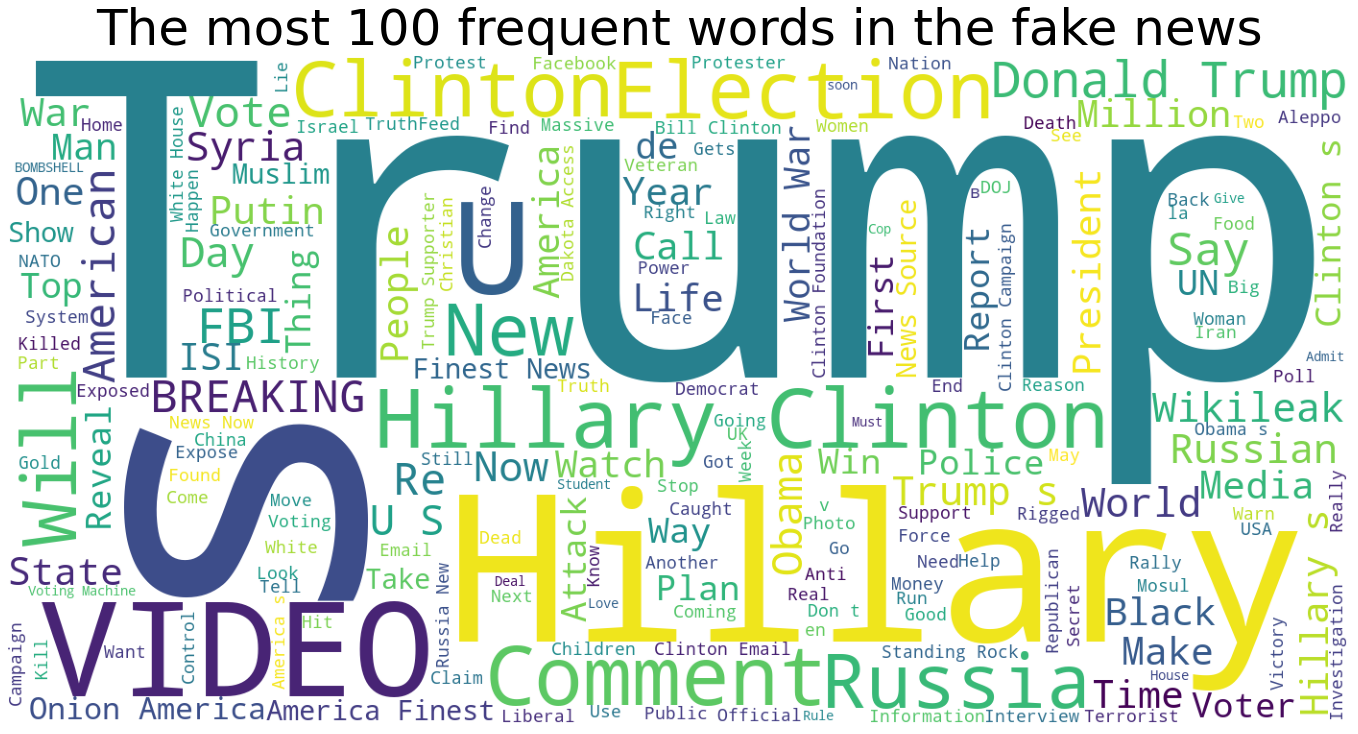

In [62]:
wordcloud = WordCloud(width=1400, height=700, background_color='white').generate(' '.join(fake.title.tolist()))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud)
plt.axis('off')
plt.title('The most 100 frequent words in the fake news', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

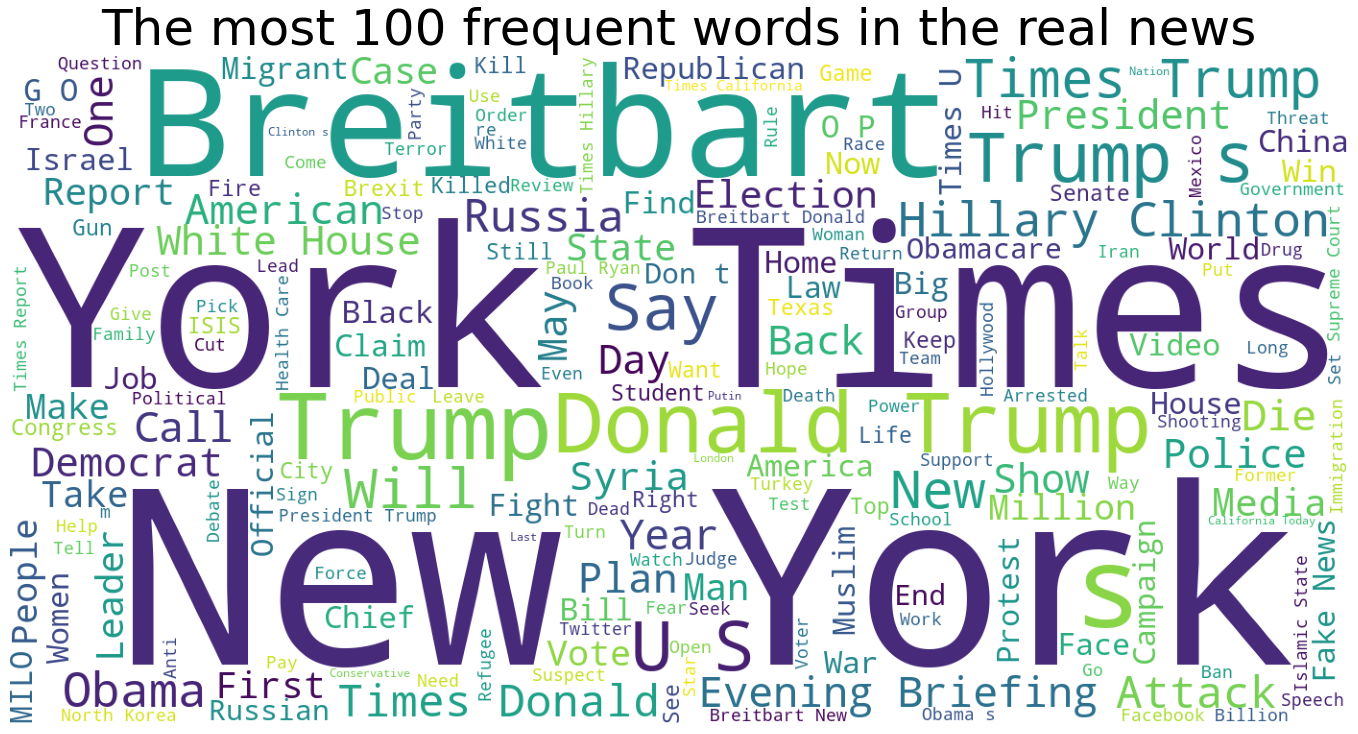

In [63]:
wordcloud = WordCloud(width=1400, height=700, background_color='white').generate(' '.join(real.title.tolist()))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud)
plt.axis('off')
plt.title('The most 100 frequent words in the real news', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

In [ ]:
y = df.label
x = df.drop('label', axis = 1)

In [12]:
texts = x.copy()
texts.reset_index(inplace = True, drop = True)
texts.head()

,title,text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ..."
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...


## Text Preprocessing

In [17]:
ps = PorterStemmer()
corpus = []

for i in tqdm(range(0, len(texts))) :
    cleaned = re.sub('[^a-zA-Z]', ' ', texts['title'][i])
    #cleaned = re.sub('[^a-zA-Z]', ' ', messages['title'][i])
    cleaned = cleaned.lower().split()
    
    cleaned = [ps.stem(word) for word in cleaned if not word in stopwords.words('english')]
    cleaned = ' '.join(cleaned)
    corpus.append(cleaned)

100%|████████████████████████████████████████████████████████████████████████████| 20203/20203 [36:52<00:00,  9.13it/s]


In [32]:
DIM = 100

X = [d.split() for d in corpus]
w2v_model = gensim.models.Word2Vec(sentences = X, vector_size = DIM, window = 10, min_count = 1)

# let's see how many vocabulary words there
len(w2v_model.wv.key_to_index.keys()) 

14717

In [76]:
# we can find similar words to a specific one, let's try with the word 'life'
w2v_model.wv.most_similar('life')

[('one', 0.9996779561042786),
 ('young', 0.9996604323387146),
 ('mani', 0.9995976686477661),
 ('billion', 0.9995933771133423),
 ('love', 0.999592125415802),
 ('offer', 0.9995801448822021),
 ('open', 0.9995365142822266),
 ('death', 0.9995307326316833),
 ('doctor', 0.9995094537734985),
 ('ex', 0.9995052814483643)]

In [35]:
tokenizer = Tokenizer()
# we convert X into sequences of numbers
tokenizer.fit_on_texts(X) 

In [36]:
X = tokenizer.texts_to_sequences(X)
# gives the indexes of words in our vocabulary
X 

[[32, 247, 248, 60, 149, 101, 504, 1520, 2730, 429],
 [925, 7, 6, 110, 137, 1183, 5],
 [321, 887, 33, 85],
 [532, 34, 1143, 16, 862, 1664],
 [1254, 137, 623, 3507, 8267, 255, 137, 1583, 127, 8268],
 [2955, 2731, 375, 176, 272, 4, 220, 128, 295, 1219, 2257, 1300, 278, 15, 5],
 [73, 73, 2732, 4411, 151, 1913, 2552, 948, 3906, 322, 8269, 810],
 [6250, 6251, 50, 407, 2553, 117, 169, 949, 1, 3, 2],
 [5107, 2017, 2391, 8, 4, 3907, 6252, 49, 676, 1743, 1, 3, 2],
 [57, 1301, 39, 826, 14, 6253, 4, 1255, 1, 3, 2],
 [12, 888, 591, 2018, 284, 360, 8270, 1348, 4, 827],
 [1256, 2019, 5108, 159, 6254, 86, 386, 1076],
 [43, 1184, 732, 199, 1077, 231, 677, 3908, 3192, 2733, 273],
 [16, 103, 149, 360, 4, 14],
 [1914, 733, 94, 1302, 433, 36, 1461, 3193, 1043],
 [387, 1407, 1521, 5109, 79, 141, 950, 1, 3, 2],
 [811, 1584, 194, 5110, 351, 1, 3, 2],
 [1007, 709, 243, 68, 185, 828, 107, 368, 408, 291],
 [28, 256, 7],
 [1915, 2020, 2149, 8, 4, 71, 829, 5],
 [13, 308, 264, 2956, 131, 208, 635, 8271, 3194, 1349

In [37]:
# we check our dictionary, we see that indexes start from 1
tokenizer.word_index 

{'new': 1,
 'time': 2,
 'york': 3,
 'trump': 4,
 'breitbart': 5,
 'clinton': 6,
 'hillari': 7,
 'donald': 8,
 'elect': 9,
 'u': 10,
 'say': 11,
 'obama': 12,
 'news': 13,
 'russia': 14,
 'video': 15,
 'us': 16,
 'presid': 17,
 'war': 18,
 'state': 19,
 'vote': 20,
 'america': 21,
 'report': 22,
 'american': 23,
 'world': 24,
 'day': 25,
 'year': 26,
 'attack': 27,
 'fbi': 28,
 'email': 29,
 'comment': 30,
 'call': 31,
 'hous': 32,
 'get': 33,
 'kill': 34,
 'white': 35,
 'media': 36,
 'polic': 37,
 'campaign': 38,
 'plan': 39,
 'protest': 40,
 'support': 41,
 'democrat': 42,
 'russian': 43,
 'syria': 44,
 'bill': 45,
 'one': 46,
 'make': 47,
 'first': 48,
 'black': 49,
 'win': 50,
 'show': 51,
 'break': 52,
 'right': 53,
 'brief': 54,
 'man': 55,
 'take': 56,
 'back': 57,
 'anti': 58,
 'peopl': 59,
 'even': 60,
 'nation': 61,
 'watch': 62,
 'go': 63,
 'like': 64,
 'use': 65,
 'investig': 66,
 'may': 67,
 'million': 68,
 'die': 69,
 'putin': 70,
 'polit': 71,
 'wikileak': 72,
 'life': 73

In [54]:
# let's convert all the sentences to have the same length which is 20 in our case
X = pad_sequences(X, padding = 'pre', maxlen = 20)

In [43]:
vocab_size = len(tokenizer.word_index) + 1 
vocab = tokenizer.word_index

In [44]:
# we can feed these vectors as initial weights to our model then recreate these vectors to get better accuracy
def get_weights_matrix(model) :
    weights_matrix = np.zeros((vocab_size, DIM))
    
    for word, i in vocab.items() :
        weights_matrix[i] = model.wv[word]
        
    return weights_matrix


embedding_vectors = get_weights_matrix(w2v_model) 

## Model Training and Evaluation

In [64]:
# creating the model
model = Sequential()

model.add(Embedding(vocab_size, output_dim = DIM, weights = [embedding_vectors], input_length = 20)) 
model.add(Dropout(0.2))

model.add(LSTM(100))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'sigmoid'))

In [65]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 100)           1471800   
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 1,552,301
Trainable params: 1,552,301
Non-trainable params: 0
_________________________________________________________________


In [66]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 2, batch_size = 64)

Epoch 1/2
253/253 [==============================] - 159s 457ms/step - loss: 0.2776 - accuracy: 0.8845 - val_loss: 0.1835 - val_accuracy: 0.9201
Epoch 2/2
253/253 [==============================] - 86s 341ms/step - loss: 0.1415 - accuracy: 0.9426 - val_loss: 0.1617 - val_accuracy: 0.9391


In [67]:
# because we used sigmoid function, which gives probabilities we convert the predictions into zeros and ones
pred = (model.predict(x_test) >= 0.5).astype(int)

In [69]:
accuracy_score(pred, y_test)

0.9391239792130661

<AxesSubplot:>

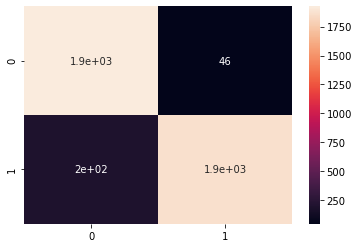

In [71]:
sns.heatmap(confusion_matrix(pred, y_test), annot = True)

In [80]:
# let's test now with a random sentence to wee what we wil get
new_text = ['New news, there is an accident in Agadir city ... a too horrifying accident']

new_text = tokenizer.texts_to_sequences(new_text)
new_text = pad_sequences(new_text, maxlen = 20)

(model.predict(new_text) >= 0.5).astype(int)[0][0] # it gives 1 which means a fake new

1